# Loading packages 

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.core.display import HTML 
from IPython.display import Image

# Loading Data

In [107]:
df_sales_raw = pd.read_csv('train.csv', low_memory = False)
df_store_raw = pd.read_csv('store.csv', low_memory = False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on ='Store')

In [108]:
df_raw.shape

(1017209, 18)

In [109]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data Description 

In [110]:
df1 = df_raw.copy()

### Renaming columns

In [111]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [112]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

### Data Dimensions

In [113]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


### Data types

In [114]:
df1['date']= pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### Checking NA's

In [115]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### Fillout NA's

In [116]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
589662,613,7,2014-01-19,0,0,0,0,0,0,c,a,250.0,6.0,2007.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [117]:
#competition_distance              
df1['competition_distance'] = df1['competition_distance'].apply(lambda x:200000.0 if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month']= df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis =1)

#competition_open_since_year     
df1['competition_open_since_year']= df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis =1)                       

#promo2_since_week               
df1['promo2_since_week']= df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis =1)                       

#promo2_since_year               
df1['promo2_since_year']= df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis =1)                       

#promo_interval                  
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec',}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo']= df1[['promo_interval', 'month_map']].apply(lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1 )




In [118]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### Change types

In [119]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [120]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week']=df1['promo2_since_week'].astype(int)
df1['promo2_since_year']=df1['promo2_since_year'].astype(int)

### Descriptive Statistics 

In [121]:
num_attributes = df1.select_dtypes(include = ['int64','int32','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','int32', 'float64','datetime64[ns]'])

In [122]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
10227,193,3,4202,732,1,0,0,520.0,7,2015,0,30,2015,0
685572,633,5,7647,571,1,1,0,11640.0,4,2005,1,22,2011,1


#### Numerical Attributes

In [123]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min )).T
d3 = pd.DataFrame(num_attributes.apply(max )).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate 
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Windows\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

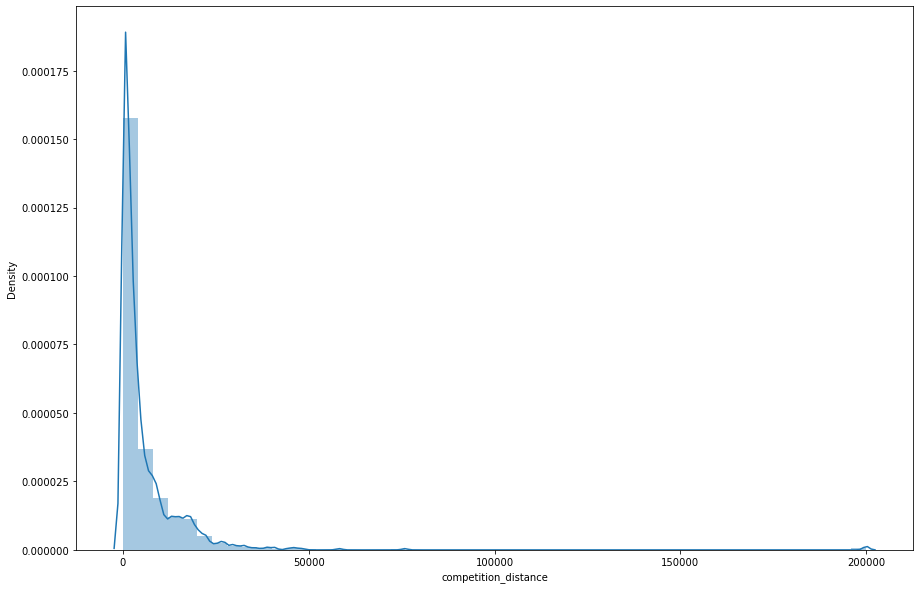

In [124]:
sns.distplot(df1['competition_distance'])

### Categorial Atrributes

In [125]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

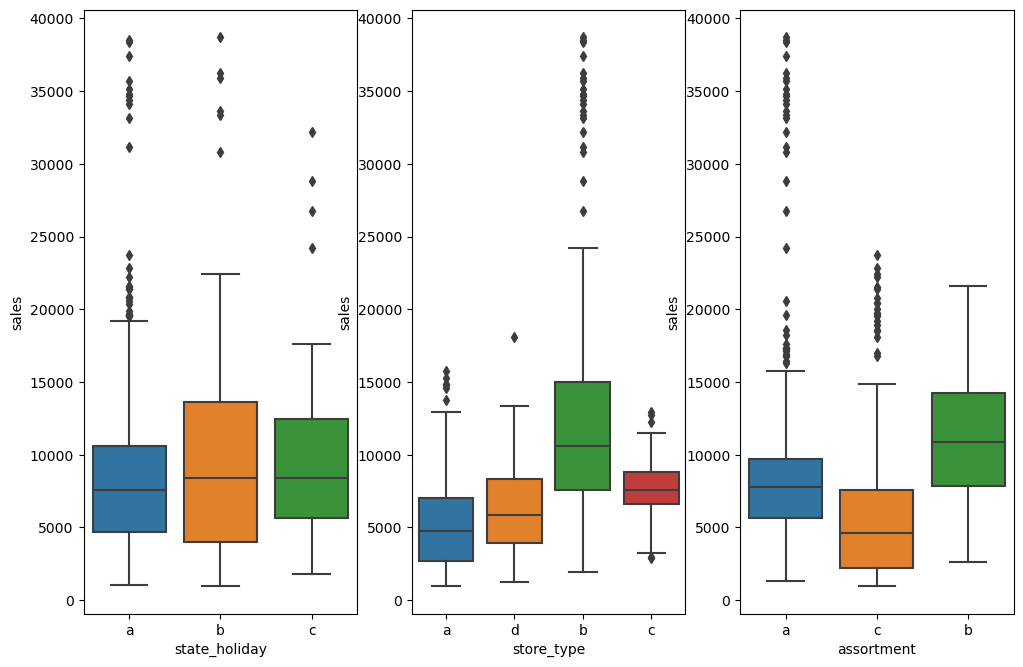

In [126]:
aux_1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)] 

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales',  data = aux_1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales',  data = aux_1)

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales',  data = aux_1)


#  Feature engineering 

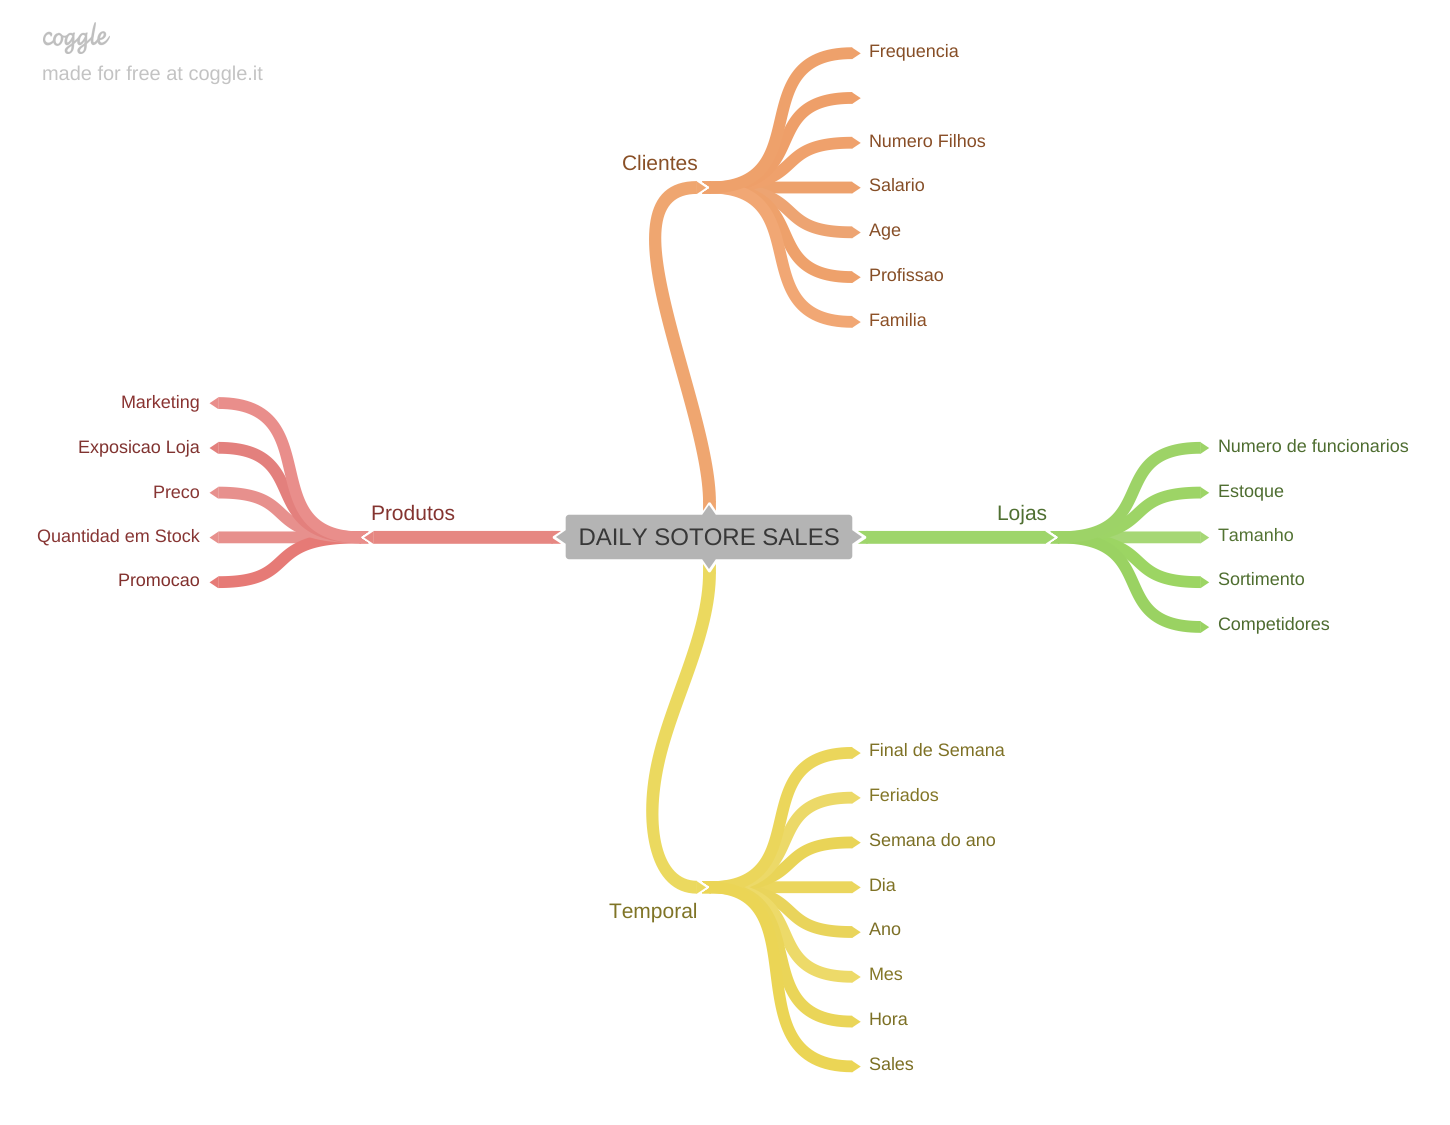

In [127]:
Image('img/DAILY_SOTORE_SALES.png')

## Hypothesis creation

### Store hypothesis

**1.** Higher number of employees should lead to higher selling volume

**2.** Higher stocked stores should lead to higher selling volume

**3.** Bigger stores should lead to higher selling volume

**4.** Better assortment in stores should lead to higher selling volume

**5.** Stores having competitors nearby should have less selling volume

**6.** Stores having lasting competitors nearby should have less selling volume

### Product hypothesis

**1.** Stores investing more in marketing should lead to higher selling volume

**2.** The more products being exposed in showcase should lead to higher selling volume

**3.** Stores displaying less priced product should lead to higher selling volume

**4.** Stores displaying less priced product longer should lead to higher selling volume

**5.** The more aggressive a promo is, the higher the selling volume

**6.** Stores displaying longer promos should have a higher selling volume 

**7.** More days with an active promo should lead to higher selling volume 

**8.** Stores displaying more consecutive promos should have higher selling volume

### Time hypothesis

**1.** Stores having more holidays should lead to lesser selling volume

**2.** Stores should have higher sellings through years

**3.** Stores should have higher selling volume on second semester each year

**4.** Stores should have higher selling volume after day 10 of month

**5.** Stores should have lesser selling volume on weekends

**6.** Stores shoudl have lesser selling volume on school holidays

## Final list of hypothesis. 

**1.** Better assortment in stores should lead to higher selling volume

**2.** Stores having competitors nearby should have less selling volume

**3.** Stores having lasting competitors nearby should have less selling volume

**4.** Stores displaying longer promos should have a higher selling volume 

**5.** More days with an active promo should lead to higher selling volume 

**6.** Stores displaying more consecutive promos should have higher selling volume

**7.** Stores having more holidays should lead to lesser selling volume

**8.** Stores should have higher sellings through years

**9.** Stores should have higher selling volume on second semester each year

**10.** Stores should have higher selling volume after day 10 of month

**11.** Stores should have lesser selling volume on weekends

**12.** Stores shoudl have lesser selling volume on school holidays

## Feature engineering

In [128]:
# year
df1['year'] = df1['date'].dt.year
# month
df1['month'] = df1['date'].dt.month
# day
df1['day'] = df1['date'].dt.day
# week of the year
df1['week_of_year'] = df1['date'].dt.weekofyear
# year week
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')

# competition since 
df1['competition_since'] = df1.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df1['competition_time_month'] = ((df1['date']-df1['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df1['promo_since'] = df1['promo2_since_year'].astype(str) + '-' + df1['promo2_since_week'].astype(str)
df1['promo_since'] = df1['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days= 7))
df1['promo_time_week'] = ((df1['date']-df1['promo_since'])/7).apply(lambda x: x.days).astype(int)
# assortment
df1['assortment'] = df1['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x == 'b' else 'extended')
# state holiday
df1['state_holiday'] = df1['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'eastern_holiday' if x == 'b' else 'christimas' if x == 'c' else 'regular_day')

<ipython-input-128-4e767970fd6c>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df1['week_of_year'] = df1['date'].dt.weekofyear


In [129]:
df1.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [131]:
df1['assortment']

0             basic
1             basic
2             basic
3          extended
4             basic
             ...   
1017204       basic
1017205    extended
1017206    extended
1017207    extended
1017208    extended
Name: assortment, Length: 1017209, dtype: object

# Data Filtering 

In [132]:
df3 = df1.copy()

In [133]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Row filtering

In [134]:
df3['open']

0          1
1          1
2          1
3          1
4          1
          ..
1017204    0
1017205    0
1017206    0
1017207    0
1017208    0
Name: open, Length: 1017209, dtype: int64

In [135]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Column Selection

In [136]:
cols_drop = ['customers', 'open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [137]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# Exploratory Data Analysis (EDA)

In [138]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

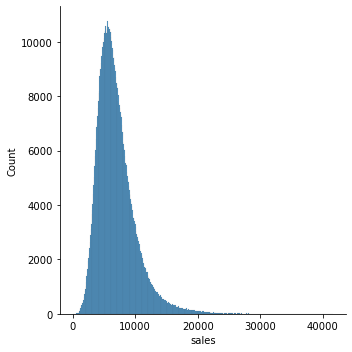

In [139]:
sns.displot(df4['sales'])

### Numerical Variable

In [140]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

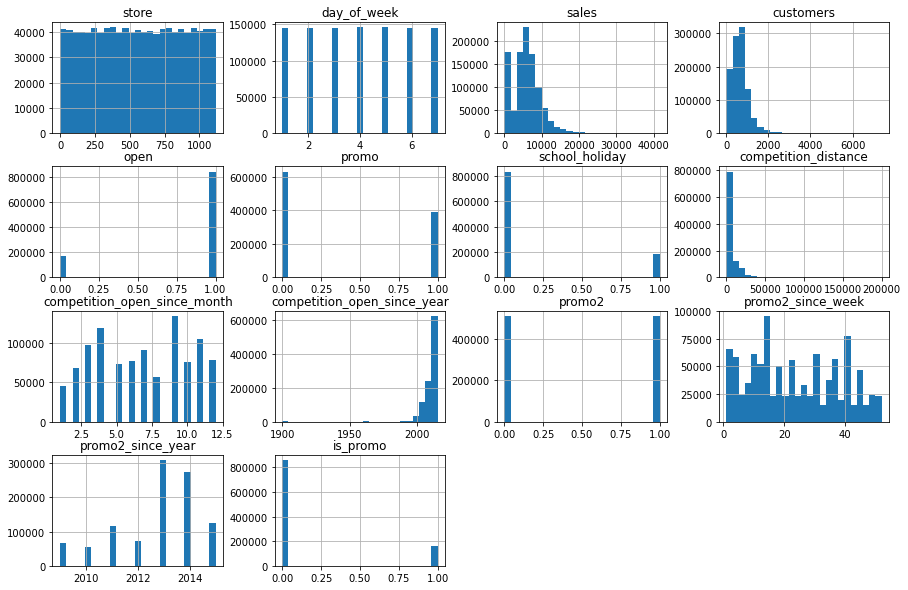

In [141]:
num_attributes.hist(bins =25);

### Categorical Variable

In [142]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [143]:
set(df4['assortment'].tolist())

{'basic', 'extended', 'extra'}

C:\Users\Windows\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Windows\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Windows\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

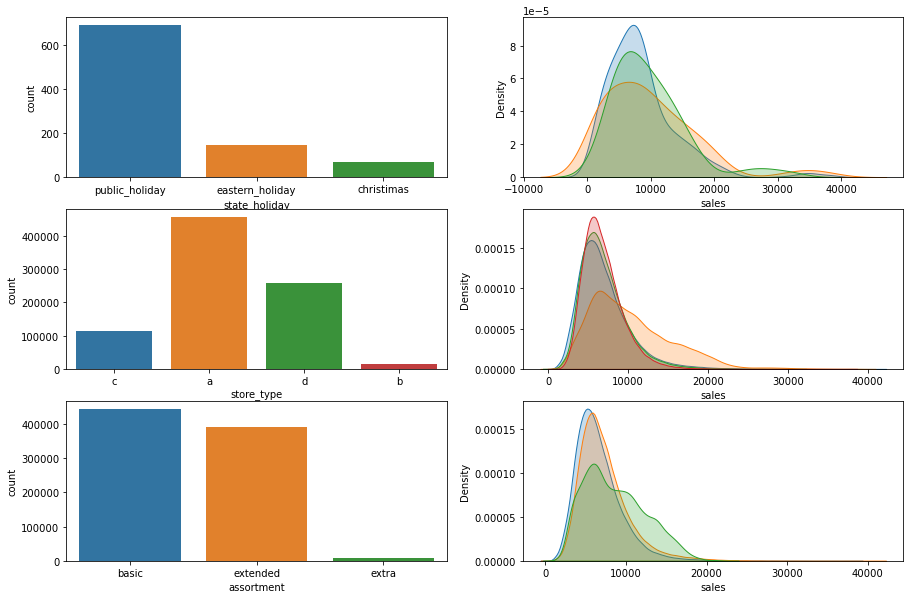

In [144]:
## State holiday
plt.subplot(3,2,1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])
plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade =True)
sns.kdeplot(df4[df4['state_holiday'] == 'eastern_holiday']['sales'], label = 'eastern_holiday', shade =True)
sns.kdeplot(df4[df4['state_holiday'] == 'christimas']['sales'], label = 'christimas', shade =True)

# store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade =True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade =True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade =True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade =True)

#Assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade =True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade =True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade =True)


## Bivariate Analysis

## Multivariable Analysis

In [25]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2

In [26]:
conn = psycopg2.connect(
            host = "127.0.0.1", 
            database = "Classroom", 
            user = "postgres", 
            password = "1032441403"
)
sql = "SELECT * FROM science_class;"
dat = sqlio.read_sql_query(sql, conn)
conn = None

In [27]:
dat

,enrollment_no,student_name,science_marks
0,4,Linnett,79
1,5,Jayden,45
2,6,Sam,63
3,7,Zooey,82
4,9,Jon,38
5,10,Sansa,54
6,11,Arya,78
7,2,Olive,54
8,3,Brutus,98
9,1,popeye,45
